In [208]:
import sys
import os
import pickle
import pandas as pd

input_seed = int(sys.argv[1])
output_path = sys.argv[2]
realizations_num = int(sys.argv[3])
run_id = int(sys.argv[4])

if not os.path.exists(output_path):
    os.makedirs(output_path)

ValueError: invalid literal for int() with base 10: '-f'

In [1]:
from __future__ import print_function, division
import matplotlib.pyplot as plt

import jax.numpy as np

from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import optimizers
import jax
import numpy as onp
import scipy
import tqdm

### Code for printing, running ESN and RLS

In [ ]:
def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:

    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

In [ ]:
def random_esn_params(key, u, n, m, tau=1.0, dt=0.1, g=1.0, i=1.0):
  """Generate random RNN parameters
  
  Arguments: 
    u: dim of the input
    n: dim of the hidden state
    m: dim of the output
    tau: "neuronal" time constant
    dt: time between Euler integration updates
    g: scaling of the recurrent matrix in the reservoir

  Returns:
    A dictionary of parameters for the ESN.
  """
  key, skeys = keygen(key, 5)
  r_density = 0.3
  hscale = 0.5
  ifactor = i / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  ffactor = 1.0 # Feedback factor, keep at 1 for now.
  #TODO sparsness
  return {'a0' : random.normal(next(skeys), (n,)) * hscale,
          'wI' : random.normal(next(skeys), (n,u)) * ifactor,
          'wR' : np.multiply(random.normal(next(skeys), (n,n)),
                             np.ones((n,n))) * hfactor,
#                              scipy.sparse.random(n, n, density=0.8, data_rvs=onp.ones).toarray()), # TODO seed
          'dt_over_tau' : dt / tau}

def esn(x, a, h, wI, wR, dtdivtau):
  """Run the continuous-time Echostate network one step.
  
    da/dt = -a + wI x + wR h + wF z

    Arguments:
      x: ndarray of input to ESN
      a: ndarray of activations (pre nonlinearity) from prev time step
      h: ndarray of hidden states from prev time step
      z: ndarray of output from prev time step
      wI: ndarray, input matrix, shape (n, u)
      wR: ndarray, recurrent matrix, shape (n, n)
      wF: ndarray, feedback matrix, shape (n, m)
      wO: ndarray, output matrix, shape (m, n)
      dtdivtau: dt / tau

    Returns: 
      The update to the ESN at this time step.
  """
  dadt = -a + np.dot(wI, x) + np.dot(wR, h)
  a = a + dtdivtau * dadt
  h = np.tanh(a)
  return a, h

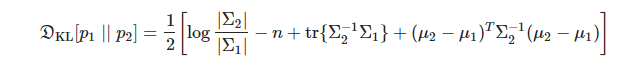

In [142]:
def multivariate_gaussian_D_js(train_mean, train_cov, target_mean, target_cov):
    return 0.5 * (multivariate_gaussian_D_kl(train_mean, train_cov, target_mean, target_cov) + multivariate_gaussian_D_kl(target_mean, target_cov, train_mean, train_cov))
        
def multivariate_gaussian_D_kl(mean1, cov1, mean2, cov2):
    d_kl=0
#     log_det1 = np.linalg.slogdet(cov1) # [value, sign]
#     log_det2 = np.linalg.slogdet(cov2)
    inv_cov2 = np.linalg.inv(cov2)
#     d_kl += log_det2[0] - log_det1[0]
    d_kl += np.log(np.abs(np.linalg.det(cov2)) / np.abs(np.linalg.det(cov1)))
    d_kl += -cov1.shape[0]
    d_kl += np.trace(np.matmul(inv_cov2, cov1))
    means_dif = mean2 - mean1
    d_kl += np.matmul(np.matmul(np.transpose(means_dif), inv_cov2), means_dif)

    return 0.5 * d_kl / np.log(2)

In [136]:
def propagate_rnn(start_time, steps, inputs, a, h, wI, wR, dtdivtau):
    samples = []
    h_t = []
    a_t = []
    for t in range(start_time, min(start_time + steps, inputs.shape[0]-1)):
        a, h = esn(inputs[t], a, h, wI, wR, dtdivtau)
        h_t.append(h)
        a_t.append(a)
        if (t - start_time) % SAMPLE_TIMESTEP == 0:#TODO add delta to remove start bias. todo - sample with random probability
            samples.append(a) # TODO activations vs state?
    return np.array(samples), h_t, a_t, a, h
        
def loss_function_batches(_wR, start_time, inputs, a_samples, h_samples, wI, _dtdivtau, target_mean, target_cov):
    samples = []
    for i in range(BATCHES_PER_GRADIENT):
        s, h_t, a_t, a, h = propagate_rnn(start_time, BATCH_SAMPLES * SAMPLE_TIMESTEP, inputs, a_samples[i], h_samples[i], wI, _wR, _dtdivtau)
        samples += list(s)
    return multivariate_gaussian_D_kl(np.mean(np.array(samples), axis=0), np.cov(np.array(samples).T), target_mean, target_cov), (h_t, a_t, a, h)

def loss_function_single_start(_wR, start_time, inputs, a, h, wI, _dtdivtau, target_mean, target_cov):
    samples, h_t, a_t, a, h = propagate_rnn(start_time, TRAIN_TIMESTEP, inputs, a, h, wI, _wR, _dtdivtau)
    return multivariate_gaussian_D_kl(np.mean(samples, axis=0), np.cov(samples.T), target_mean, target_cov), (h_t, a_t, a, h)

def esn_run_and_train_jax(params, x_t, target_mean=None, target_cov=None, opt_state=None, a_sample_tensor=None, do_train=False, step_size=1e-3):
  """Run the Echostate network forward a number of steps the length of x_t.
  
    This implementation uses JAX to build the outer time loop from basic
    Python for loop.

    Arguments: 
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of input time series, shape (t, u)
      f_t: ndarray of target time series, shape (t, m)
      do_train: Should the network be trained on this run? 
    
    Returns:
      4-tuple of params, fparams, h_t, z_t, after running ESN and potentially
        updating the readout vector.  
  """
  # per-example predictions
  a = params['a0']
  h = np.tanh(a)
  a_t = [a]  
  h_t = [h]
  loss = []

  wI = params['wI']
  wR = params['wR']
  dtdivtau = params['dt_over_tau']
  samples = []  
    
  j=0
  for t in tqdm.tqdm(range(0, x_t.shape[0] - 1, TRAIN_TIMESTEP)):
    if do_train:
        # TODO: very hacky to bypass the opt_update problem
        _, opt_update, get_params = optimizers.sgd(step_size)
        
        if TRAIN_TYPE == "batch":
            a_samples = a_sample_tensor[j]
            h_samples = np.tanh(a_samples) # TODO - switch a's and h's
            loss_function_batches(wR, t, x_t, a_samples, h_samples, wI, dtdivtau, target_mean, target_cov)
            loss_return_values , grads = value_and_grad(loss_function_batches, has_aux=True)(wR, t, x_t, a_samples, h_samples, wI, dtdivtau, target_mean, target_cov)
        else:
            loss_return_values , grads = value_and_grad(loss_function_single_start, has_aux=True)(wR, t, x_t, a, h, wI, dtdivtau, target_mean, target_cov)
        clipped_grads = optimizers.clip_grads(grads, np.square(wR.shape[0]))
        opt_state = opt_update(j, clipped_grads, opt_state)
        j+=1
        wR = get_params(opt_state)
        h_t += list(loss_return_values[1][0])
        a_t += list(loss_return_values[1][1])
        loss.append(loss_return_values[0])
    else:
        samples, h_t_new, a_t_new, a, h = propagate_rnn(t, TRAIN_TIMESTEP, x_t, a, h, wI, wR, dtdivtau)
        h_t += h_t_new
        a_t += a_t_new
        
        
  params['wR'] = wR
  h_t = np.array(h_t)
  a_t = np.array(a_t)
  
  return params, h_t, a_t, loss, opt_state

In [137]:
def esn_run_jax(params, x_t):
  """Run the echostate network forward.

    Arguments:
      params: dict of ESN params
      x_t: ndarray of input with shape (t,u)

    Returns: 
      2-tuple of ndarrays with first dim time, the hidden state and the outputs.
  """
  return esn_run_and_train_jax(params, x_t, None, None, None, None, do_train=False)

esn_run_jax_jit = jit(esn_run_jax)


def esn_train_jax(params, x_t, target_mean, target_cov, opt_state, a_sample_tensor, step_size):
  """Run the echostate network forward and also train it.

    Arguments:
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of inputs with shape (t,u)
      f_t: ndarray of targets with shape (t,m)

    Returns: 
      4-tuple of updated params, fparams, and also ndarrays with first dim 
        time, the hidden state and the outputs.
  """
  return esn_run_and_train_jax(params, x_t, target_mean, target_cov, opt_state, a_sample_tensor, do_train=True, step_size=step_size)
  
esn_train_jax_jit = jit(esn_train_jax)

In [160]:
# Basic parameters of the Echostate networks
key = random.PRNGKey(0)   
    
T = 160              # total time
u = 1               # number of inputs (didn't bother to set up zero, just put in zeros)
n = 5             # size of the reservoir in the ESN
tau = 1.0           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

x_t = np.zeros((ntime,u)) # Just a stand-in in folks want a real input later
x_t = np.ones((ntime,u)) # Just a stand-in in folks want a real input later

TRAIN_TYPE = "batch"
BATCHES_PER_GRADIENT = 16
BATCH_SAMPLES = 10
SAMPLE_TIMESTEP = 1

if TRAIN_TYPE == "batch":
    TRAIN_TIMESTEP = BATCH_SAMPLES * SAMPLE_TIMESTEP * BATCHES_PER_GRADIENT
else:
    TRAIN_TIMESTEP = BATCH_SAMPLES * SAMPLE_TIMESTEP

Note well, the first time jit'd functions run they take a LONG TIME because there is no jax scan function, so it's unrolling a huge graph proportional to the number of time steps!  Afterwards, it's blazingly fast.  A scan function is in the works.

Data seed: 566803


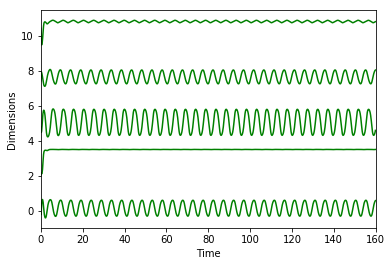

In [304]:
# Generate some target data by running an ESN, and just grabbing hidden 
# dimensions as the targets of the FORCE trained network.

g = 5.5  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
m = n   # Number of targets, and thus outputs for trained ESN.
i=1

try:
    data_seed = input_seed
except:
    data_seed = onp.random.randint(0, 10000000)
# data_seed = 7437601 # 8, 6.5
# data_seed = 8180034 # 8, 6.5
# data_seed = 6815275 # 8, 6.5
# data_seed = 9586903 # 4, 4.5
# data_seed = 3339618 # 4, 4.5, 1
# data_seed = 2794038, 2829716, 9039831, 566803
# data_seed = 2829716
print("Data seed: %d" % (data_seed))
key = random.PRNGKey(data_seed)
data_params = random_esn_params(key, u, n, m, g=g, i=i)

_, h_t_target, a_t_target, _, _ = esn_run_jax_jit(data_params, x_t)

plt.plot(time, h_t_target[:,0:m] + 2.5*onp.arange(0, m), 'g');
plt.xlim((0, T))
plt.ylabel('Dimensions')
plt.xlabel('Time');

### Regular Train

In [321]:
def run_realization(a_target, h_target, n, g, data_seed = None, 
                    ntraining=1000, initial_step_size=5e-1, should_print=False):
    target_h = h_target.copy()
    target_a = a_target.copy()
    target_mean = np.mean(target_a[0::SAMPLE_TIMESTEP], axis=0) #TODO a\h
    target_cov = np.cov(target_a[0::SAMPLE_TIMESTEP].T)
    target_data_params = data_params.copy()
    train_data_params = data_params.copy()

    if data_seed is None:
        data_seed = onp.random.randint(0, 10000000)
    else:
        data_seed = onp.random.randint(0, 10000000) + data_seed
    print("Data seed: %d" % (data_seed))
    onp.random.seed(data_seed)
    key = random.PRNGKey(data_seed)
    key, skeys = keygen(key, 5)
    train_data_params['wR'] = random.normal(next(skeys), (n,n)) * g / np.sqrt(n)

    step_size = initial_step_size
    opt_init, opt_update, get_params = optimizers.sgd(step_size)
    opt_state = opt_init(train_data_params['wR'])

    tot_loss_train = []
    tot_loss_test = []

    best_data_params = None
    best_loss_test = 10e10

    # data_params = random_esn_params(key, u, n, m, g=g)

    for train_idx in range(ntraining+1):
        if train_idx >= 0:
            a_samples_tensor = onp.random.multivariate_normal(target_mean,target_cov, (int(x_t.shape[0]/TRAIN_TIMESTEP)+1, BATCHES_PER_GRADIENT))
            train_data_params, h_t, a_t, loss, opt_state = esn_train_jax_jit(train_data_params, x_t, target_mean, target_cov, opt_state, a_samples_tensor, step_size)
            tot_loss_train += loss
        if train_idx % 100 == 0:
            step_size = step_size / 2


        
        _, h_t, a_t, _, _ = esn_run_jax_jit(train_data_params, x_t)
        train_mean = np.mean(a_t[::SAMPLE_TIMESTEP], axis=0) #TODO a\h
        train_cov = np.cov(a_t[::SAMPLE_TIMESTEP].T)
        tot_loss_test.append(multivariate_gaussian_D_kl(train_mean, train_cov, target_mean, target_cov))

        if tot_loss_test[-1] < best_loss_test:
            best_loss_test = tot_loss_test[-1]
            best_data_params = train_data_params.copy()

        if train_idx % 200 == 0 and should_print:
            fig = plt.figure(constrained_layout=True, figsize=(15, 4))
            gs = fig.add_gridspec(2, 2)
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.set_xlim((0, T))
            ax1.set_ylabel('Dimensions')
            ax1.set_xlabel('Time');
            ax1.set_title("epoch: %d" % (train_idx))
            ax1.plot(time, h_t + 2.5*onp.arange(0, m), 'g');

            ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
            ax2.set_xlim((0, T))
            ax2.set_ylabel('Dimensions')
            ax2.set_xlabel('Time');
            ax2.set_title("epoch: %d" % (train_idx))
            ax2.plot(time, target_h + 2.5*onp.arange(0, m), 'r');

            ax3 = fig.add_subplot(gs[1, 0])
            ax3.plot(np.array(tot_loss_train));
            ax3.set_yscale("log")
            ax3.set_xlabel("batch_id")
            ax3.set_ylabel("loss")

            ax4 = fig.add_subplot(gs[1, 1])
            ax4.plot(np.array(tot_loss_test));
            ax4.set_yscale("log")
            ax4.set_xlabel("epoch")
            ax4.set_ylabel("loss")

            plt.show()
            plt.pause(0.1)

    distance = np.linalg.norm(best_data_params['wR'] - target_data_params['wR'])
    normalized_distance = np.linalg.norm(best_data_params['wR'] / np.linalg.norm(best_data_params['wR']) -\
                                          target_data_params['wR'] / np.linalg.norm(target_data_params['wR']))
    corr = onp.corrcoef(best_data_params['wR'].flatten(), target_data_params['wR'].flatten())

    return {
        'distance':distance.item(),
        'normalized_distance': normalized_distance.item(),
        'corr': corr[0][1],
        'best_loss_js': best_loss_test,
        'best_params': best_data_params, 
        'last_loss_js': tot_loss_test,
        'last_params': train_data_params,
        'seed': data_seed,
    }

In [322]:
realizations_num = 500
run_id=2
input_seed=566803







  0%|          | 0/500 [00:00<?, ?it/s]

Data seed: 2222260


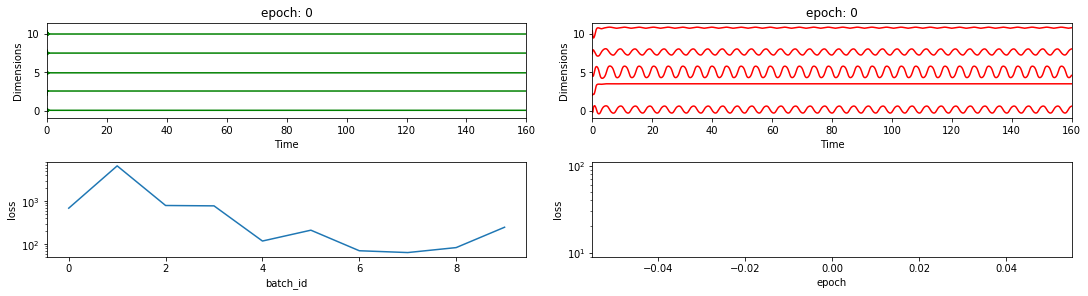

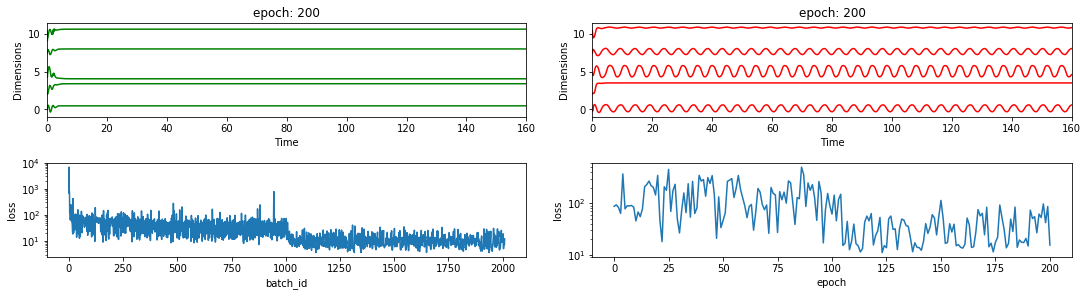

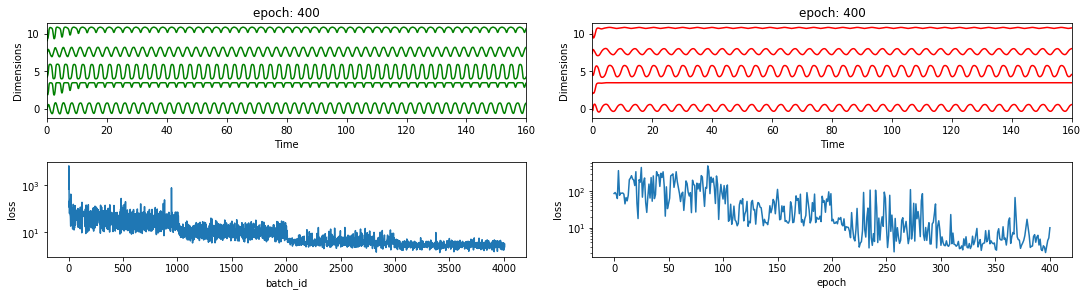

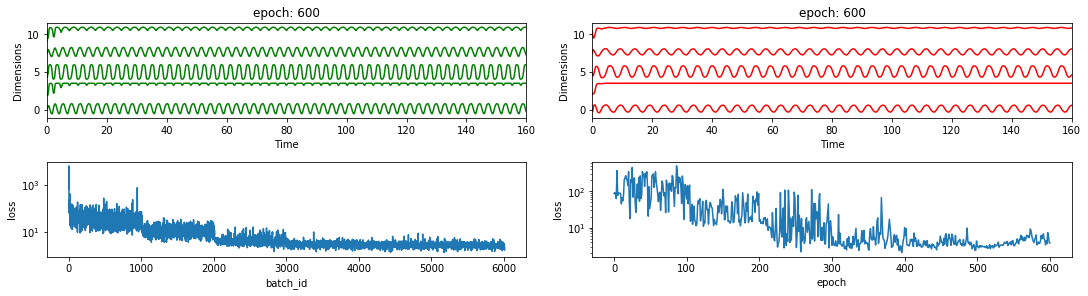

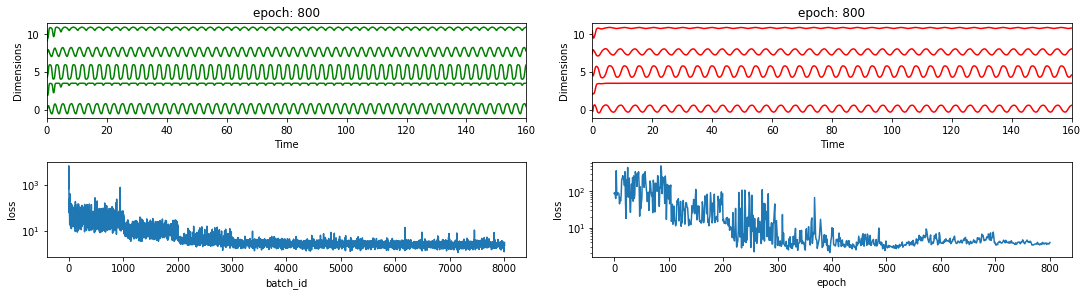

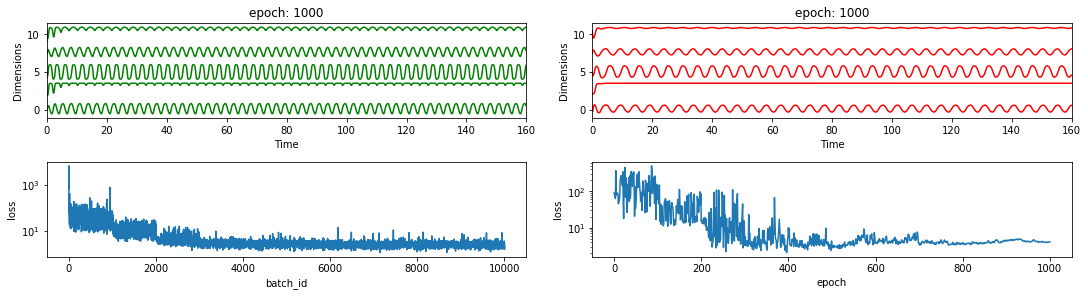







  0%|          | 1/500 [01:14<10:19:04, 74.44s/it]

Data seed: 9021712


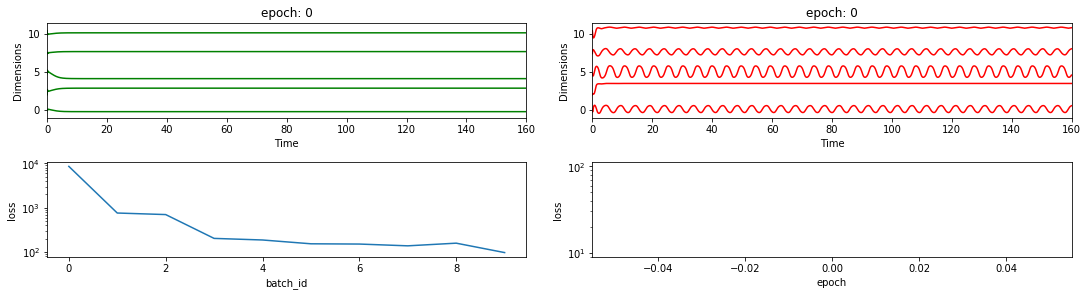

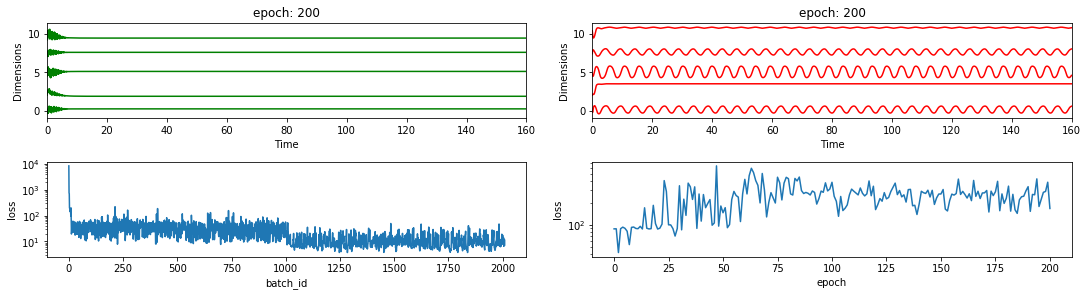

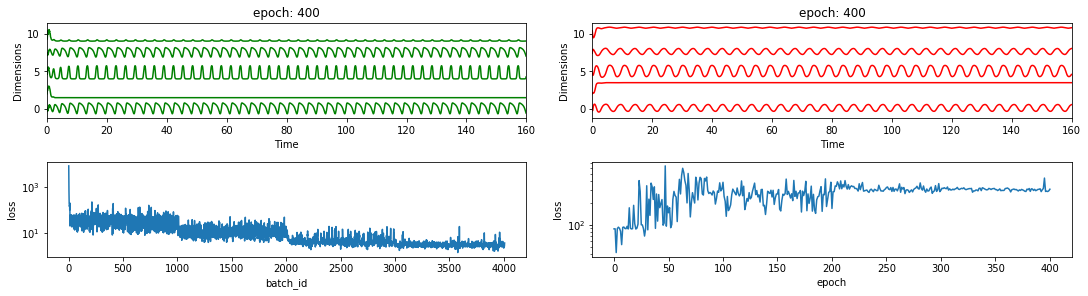

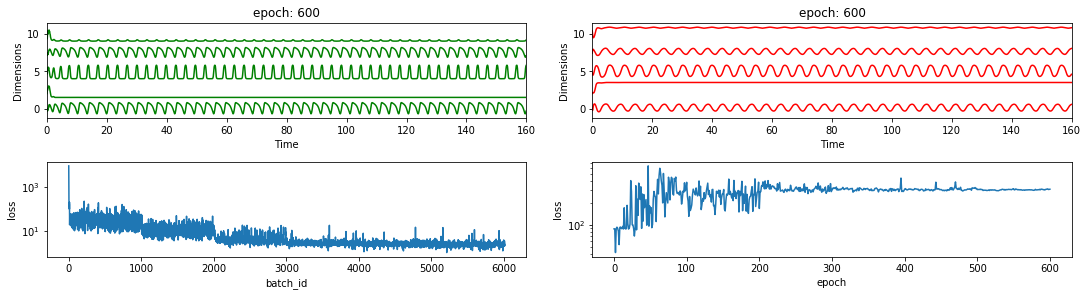

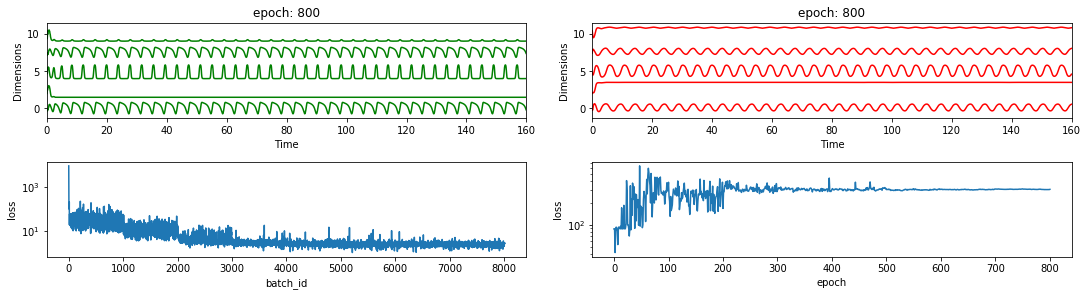

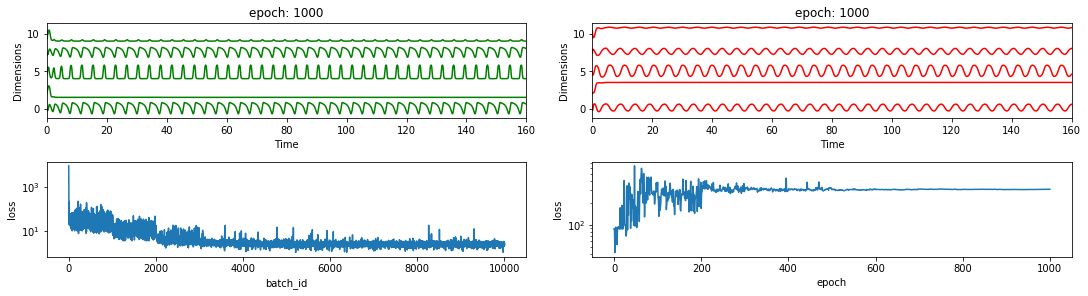







  0%|          | 2/500 [02:27<10:13:42, 73.94s/it]

Data seed: 7899835


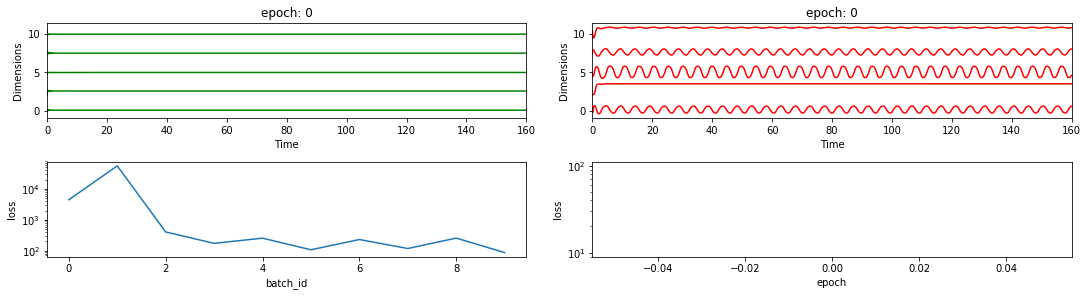

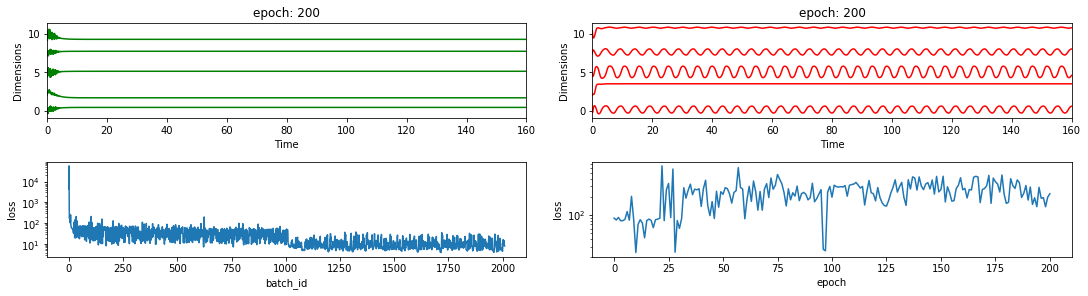

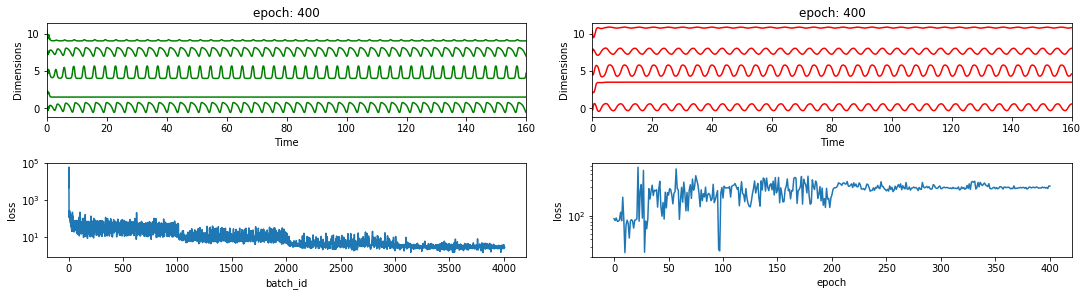

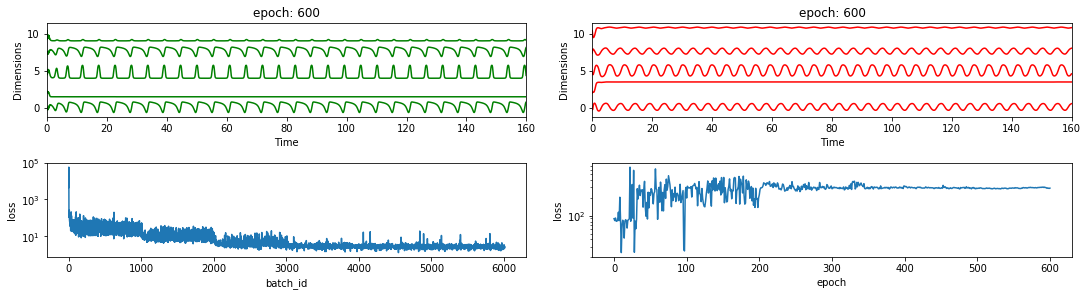

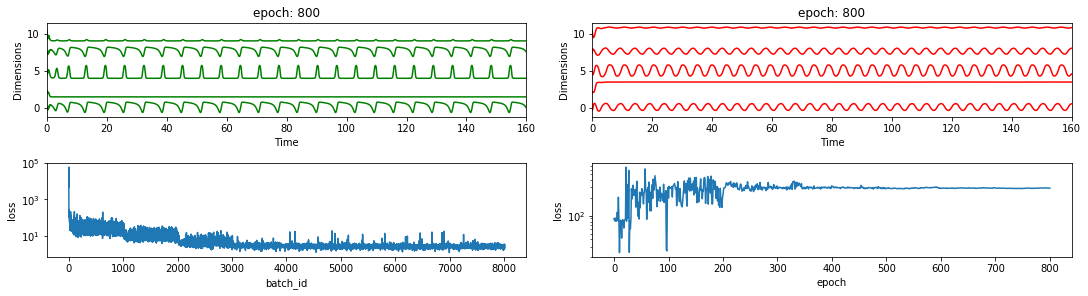

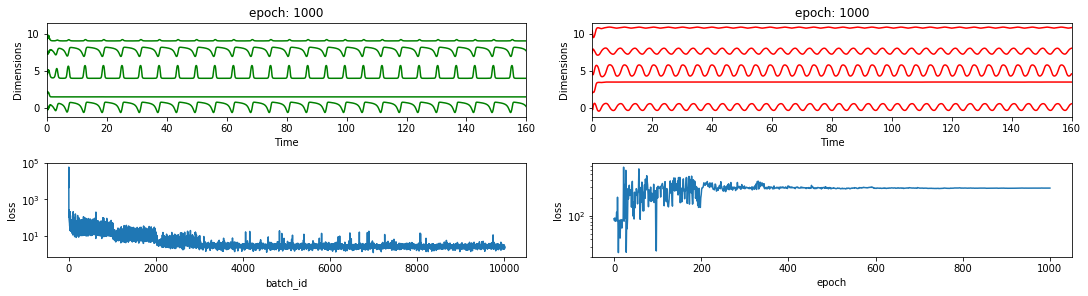







  1%|          | 3/500 [03:39<10:08:17, 73.44s/it]

Data seed: 402435


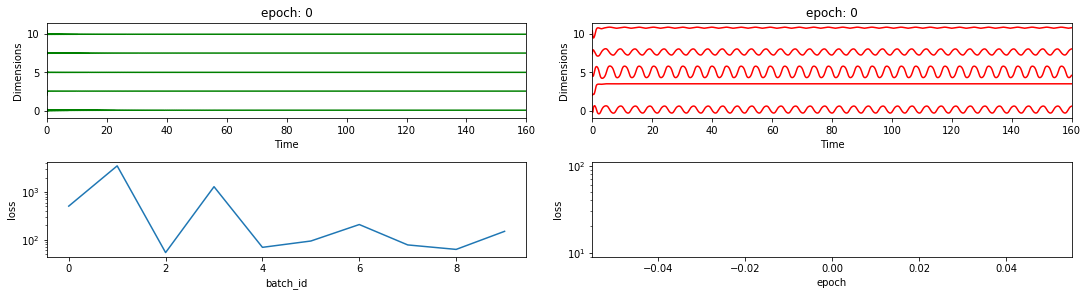

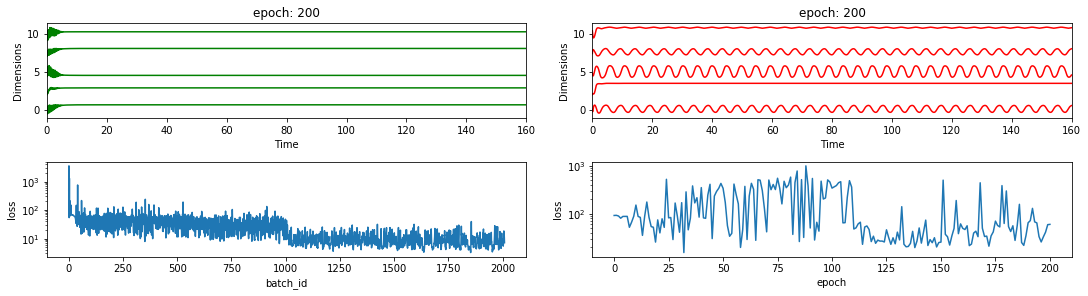

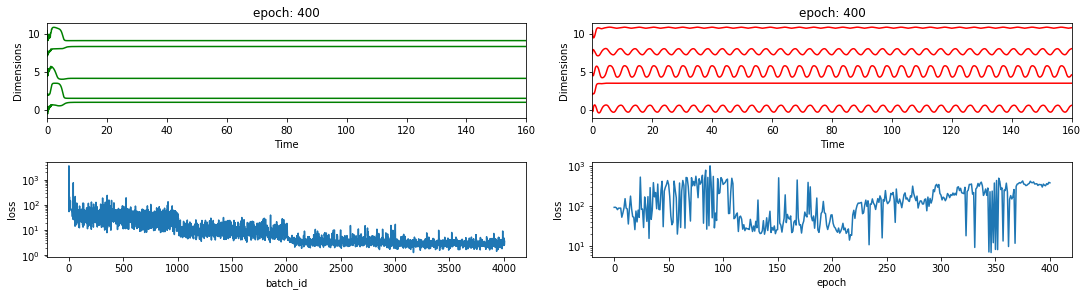

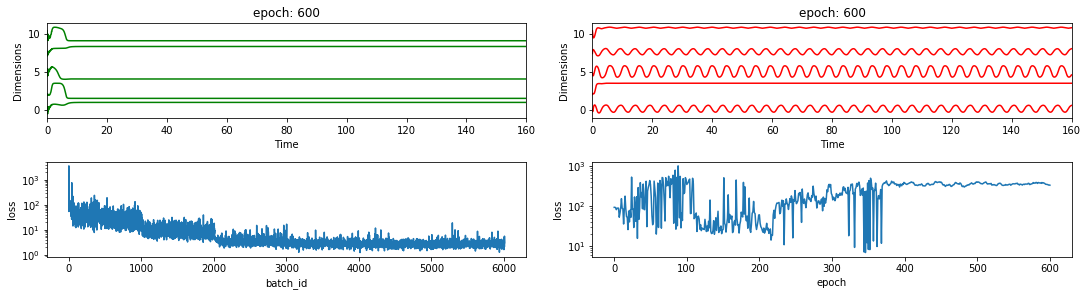

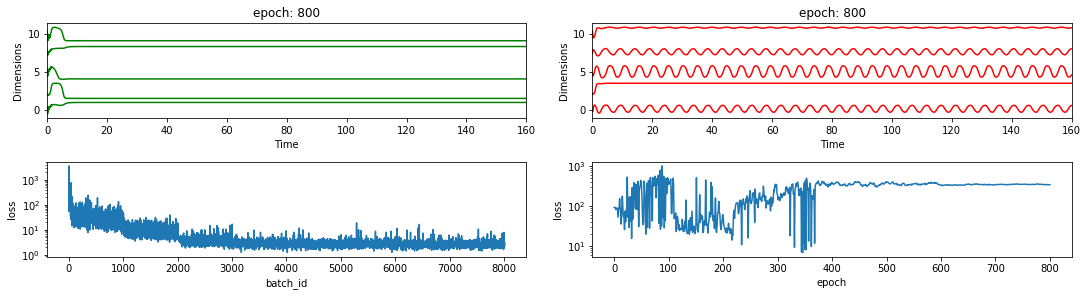

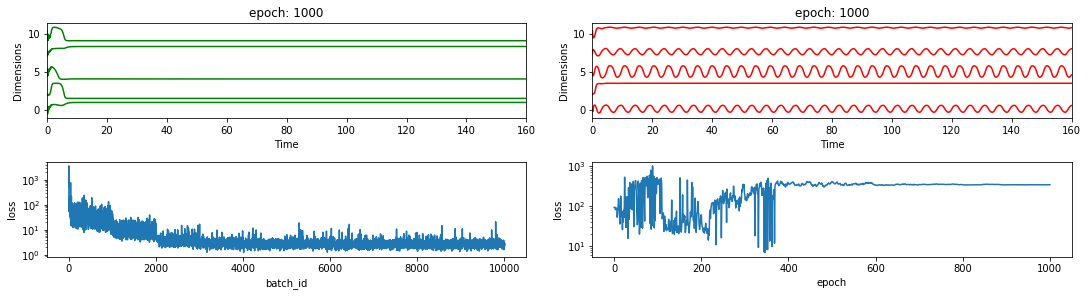







  1%|          | 4/500 [04:53<10:07:44, 73.52s/it]

Data seed: 8239418


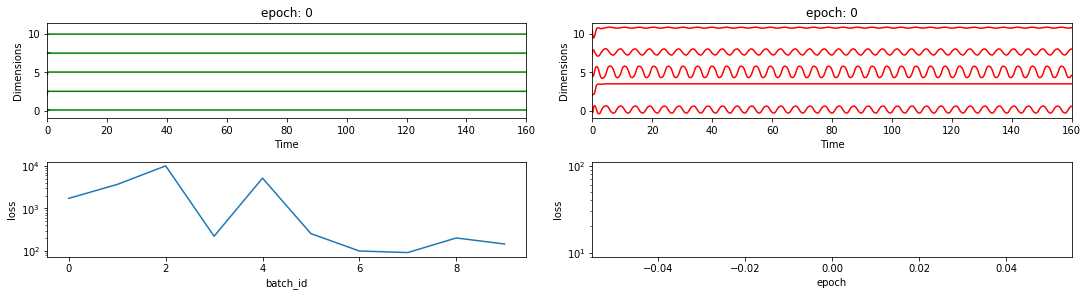

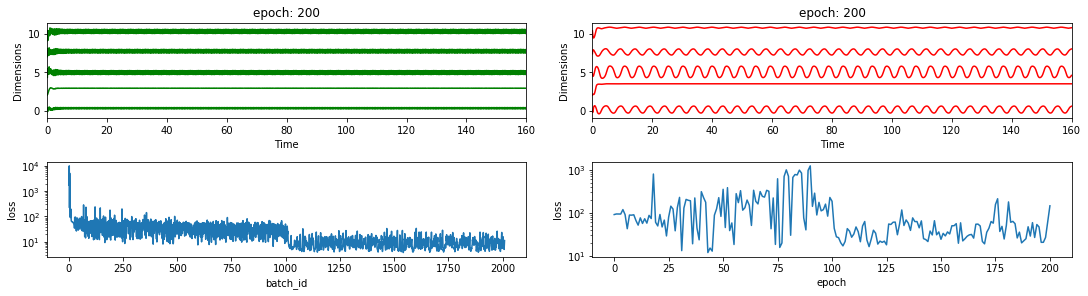

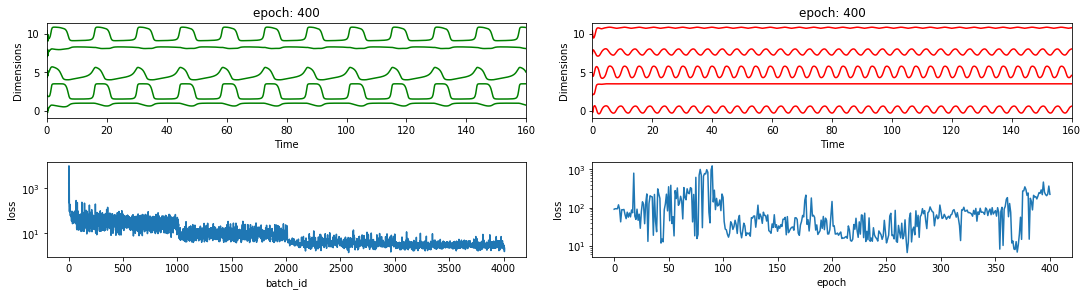

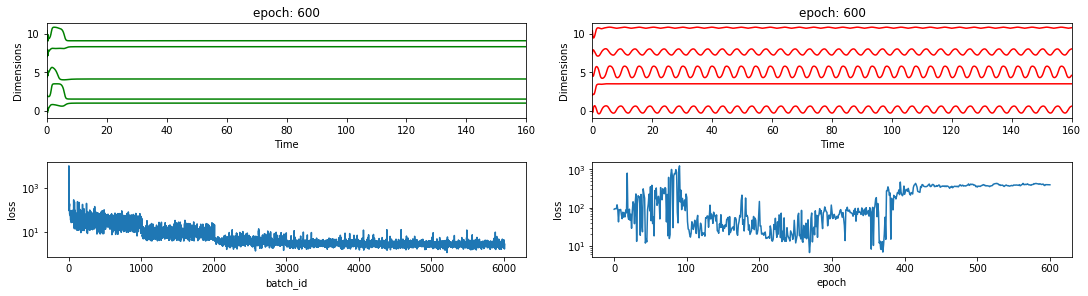

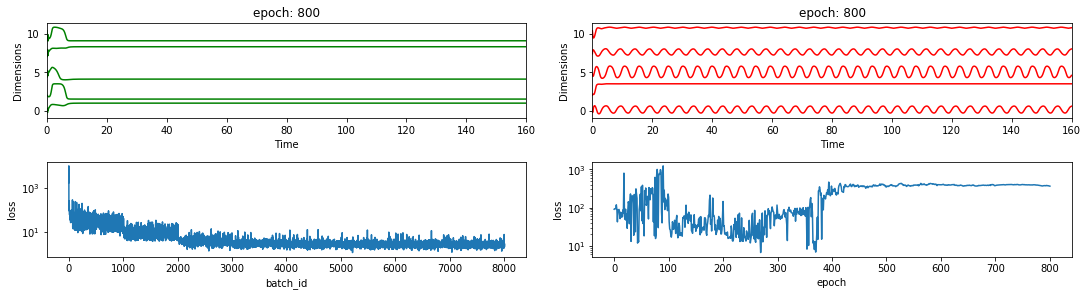

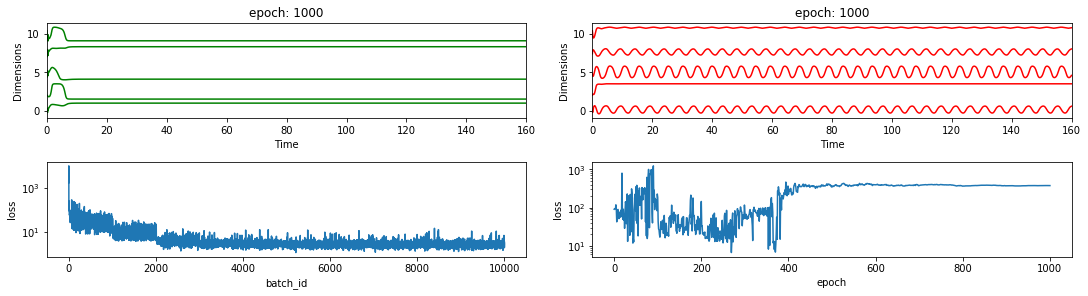







  1%|          | 5/500 [06:07<10:07:39, 73.66s/it]

Data seed: 4402058


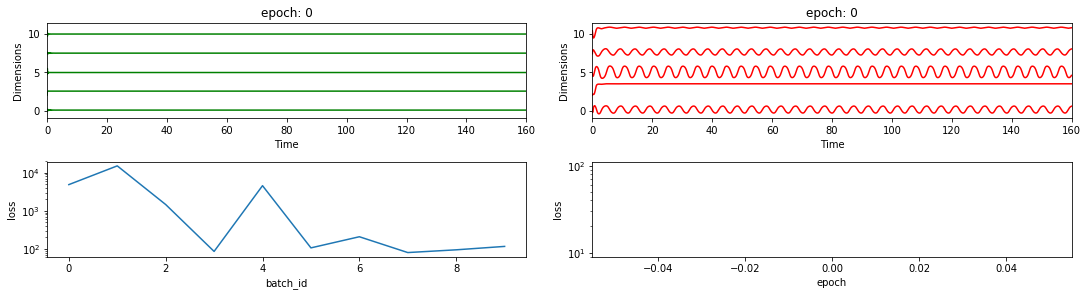

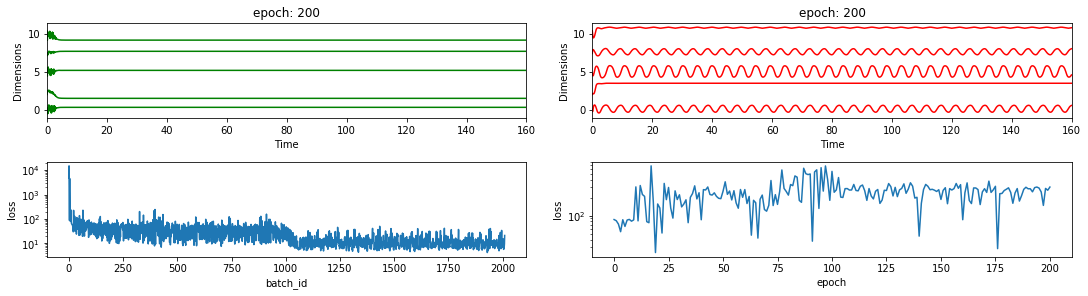

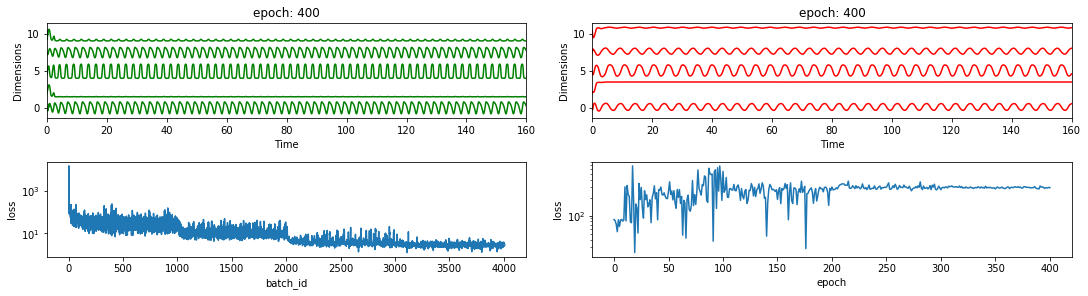

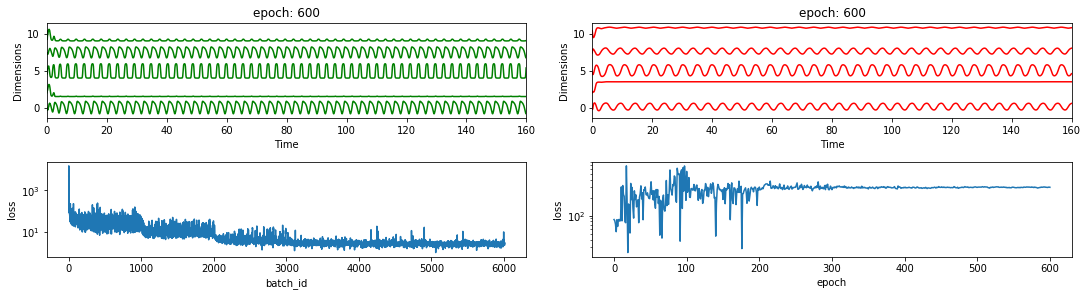

In [ ]:
x = [run_realization(a_t_target, h_t_target, n, g, ntraining=1000, should_print=True, data_seed=run_id*realizations_num+i) for i in tqdm.tqdm(range(realizations_num))]
df = pd.DataFrame.from_records(x)

In [315]:
with open(os.path.join("", "%s_seed%d__%d.pkl" % ("FR_train_output", input_seed, run_id)), 'wb') as pkl:
    pickle.dump(df, pkl)

In [305]:
with open(os.path.join(output_path, "%s_seed%d__%d.pkl" % ("FR_train_output", input_seed, run_id)), 'wb') as pkl:
    pickle.dump(df, pkl)

In [308]:
df.iloc[4]

best_loss_js                                             1.733518
best_params     {'a0': [-0.06591544, -0.5308884, -0.21272992, ...
last_loss_js    [89.07799, 93.311195, 28.283585, 38.11912, 92....
last_params     {'a0': [-0.06591544, -0.5308884, -0.21272992, ...
Name: 4, dtype: object